<a href="https://colab.research.google.com/github/prasadpb/Springer/blob/master/ParametricUMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parametric UMAP

This notebook walks you through the basic algorithm for Parametric UMAP (Sainburg, McInnes, Gentner, 2020) in a more verbose (but still high-level) way. 

The code used in the implementation subclasses umap.UMAP and replaces the fit method with a neural network. Here, we'll go through the algorithm, starting with graph construction, one step at a time. 

This tutorial is written by [Tim Sainburg](https://timsainburg.com).

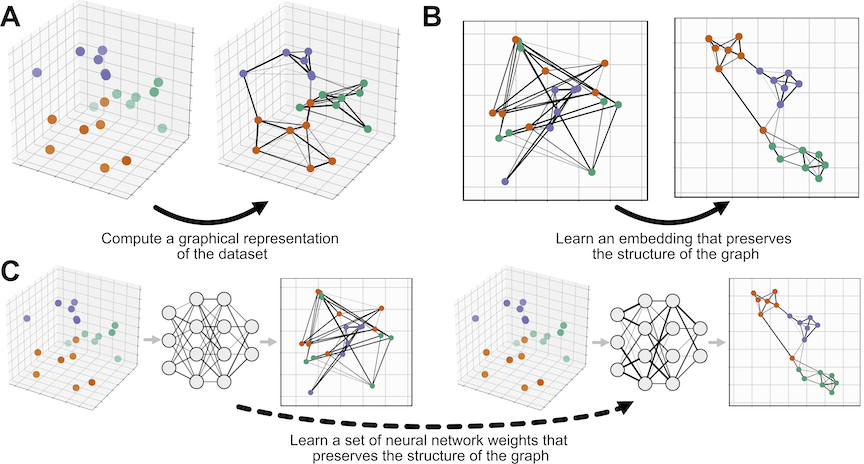

### Install packages

In [ ]:
!pip install llvmlite>=0.34.0

In [ ]:
!pip install https://github.com/lmcinnes/umap/archive/0.5dev.zip

     - 33.9MB 621kB/s
     |████████████████████████████████| 942kB 8.5MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.0-cp36-none-any.whl size=78767 sha256=4d2e530154d1b72ba948c27a0a7bc62a91705d4750dd3938a1fc758c39a177b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-8x9jv4ne/wheels/31/8a/95/86cddaaadaca56cbcf4e8f67785ac4b85514a962c8e25c05a6
Successfully built umap-learn
  Found existing installation: umap-learn 0.4.6
    Uninstalling umap-learn-0.4.6:
      Successfully uninstalled umap-learn-0.4.6


In [ ]:
!pip install pynndescent

### load dataset
We will use MNIST for this example.

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
# load dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
X = train_images.reshape((60000, 28, 28, 1))
X.shape

11493376/11490434 [==============================] - 0s 0us/step


(60000, 28, 28, 1)

## Part 1: Building the Graph

### Build nearest neighbor's graph

In [ ]:
from pynndescent import NNDescent
import numpy as np

In [ ]:
# number of trees in random projection forest
n_trees = 5 + int(round((X.shape[0]) ** 0.5 / 20.0))
# max number of nearest neighbor iters to perform
n_iters = max(5, int(round(np.log2(X.shape[0]))))
# distance metric
metric="euclidean"
# number of neighbors for computing k-neighbor graph
n_neighbors = 10

# get nearest neighbors
nnd = NNDescent(
    X.reshape((len(X), np.product(np.shape(X)[1:]))),
    n_neighbors=n_neighbors,
    metric=metric,
    n_trees=n_trees,
    n_iters=n_iters,
    max_candidates=60,
    verbose=True
)
# get indices and distances
knn_indices, knn_dists = nnd.neighbor_graph

Sun Sep 27 16:28:36 2020 Building RP forest with 17 trees
Sun Sep 27 16:28:43 2020 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations


In [ ]:
# nearest neighbors and distances for each point in the dataset
np.shape(knn_indices), np.shape(knn_dists)

((60000, 10), (60000, 10))

### Build fuzzy simplicial  complex

The `fuzzy_simplicial_set` function takes the nearest neighbor graph and computes a graph of the probabilities of an edge exists between points. 

Local, one-directional, probabilities ($P^{\textrm{UMAP}}_{i|j}$) are computed between a point and its neighbors to determine the probability with which an edge (or simplex exists), based upon an assumption that data is uniformly distributed across a manifold in a warped dataspace. Under this assumption, a local notion of distance is set by the distance to the $k$\textsuperscript{th} nearest neighbor and the local probability is scaled by that local notion of distance.

$$
p_{j \mid i}^{\textrm{UMAP}} = \exp( -(\textrm{d}( \mathbf{x}_{i},\mathbf{x}_{j}) - \rho_{i}) / \sigma_{i})
$$

Where $\rho_{i}$ is a local connectivity parameter set to the distance from $x_i$ to its nearest neighbor, and $\sigma_{i}$ is a local connectivity parameter set to match the local distance around $x_i$ upon its $k$ nearest neighbors (where $k$ is a hyperparameter). In the UMAP package, these are calculated using `smooth_knn_dist`.

After computing the one-directional edge probabilities for each datapoint, we then compute a global probability as the probability of either of the two local, one-directional, probabilities occurring:

$$
p_{i j}=\left(p_{j \mid i}+p_{i \mid j}\right)-p_{j \mid i} p_{i \mid j}
$$

In [ ]:
from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set

In [ ]:
# get indices and distances
knn_indices, knn_dists = nnd.neighbor_graph
random_state = check_random_state(None)

In [ ]:
# build fuzzy_simplicial_set
umap_graph, sigmas, rhos = fuzzy_simplicial_set(
    X = X,
    n_neighbors = n_neighbors,
    metric = metric,
    random_state = random_state,
    knn_indices= knn_indices,
    knn_dists = knn_dists,
)

In [ ]:
umap_graph

<60000x60000 sparse matrix of type '<class 'numpy.float32'>'
	with 803526 stored elements in Compressed Sparse Row format>

## Part 2: Embedding the graph

Now we learn an embedding for the graph, using a neural network. 

### Create neural network model
We first create a neural network to perform the parametric embedding. Here, we'll use a simple convolutional neural network

In [ ]:
import tensorflow as tf

In [ ]:
n_components = 2 # number of latent dimensions
dims = X.shape[1:]
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3211776   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 3,549,954
Trainable params: 3,549,954
Non-trainable params: 0
______________________________________________

### create batch iterator

We now want to create a dataset to iterate over batches of edges and their nearest-neighbors in our dataset. 

In [ ]:
from umap.parametric_umap import construct_edge_dataset

In [ ]:
# n_epochs isused to compute epochs_per_sample, which, in non-parametric UMAP, 
# is the total number of epochs to optimize embeddings over. The computed value 
# epochs_per_sample, is the number of epochs  each edge is optimized over 
# (higher probability = more epochs).
n_epochs = 200 

batch_size = 1000 # iterate over batches of 1000 edges

In [ ]:
# get tensorflow dataset of edges 
(
    edge_dataset,
    batch_size,
    n_edges,
    head,
    tail,
    edge_weight,
) = construct_edge_dataset(
    X,
    umap_graph,
    n_epochs,
    batch_size,
    parametric_embedding = True,
    parametric_reconstruction = False,
)

In [ ]:
(sample_edge_to_x, sample_edge_from_x), _ =  next(iter(edge_dataset))
sample_edge_to_x.shape

TensorShape([1000, 28, 28, 1])

In [ ]:
import matplotlib.pyplot as plt

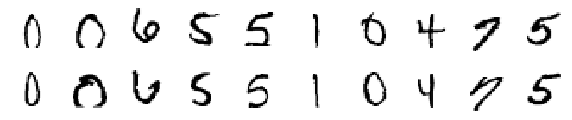

In [ ]:
# plot sampled neighbors from graph
fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(10,2))
for i in range(10):
    axs[0,i].matshow(np.squeeze(sample_edge_to_x[i]), cmap=plt.cm.Greys)
    axs[1,i].matshow((np.squeeze(sample_edge_from_x[i])), cmap=plt.cm.Greys)
    axs[0,i].axis('off')
    axs[1,i].axis('off')

### Compute loss over a batch

In [ ]:
from umap.parametric_umap import umap_loss

#### Compute $a$ and $b$ parameters. These relate to UMAP's `min_dist` hyperparameter, that determines how spread apart points are. 

In [ ]:
from umap.umap_ import find_ab_params

In [ ]:
min_dist = 0.1 # controls how tightly UMAP is allowed to pack points together (0 is more)

In [ ]:
_a, _b = find_ab_params(1.0, min_dist)

### define the loss function
First, we will through the loss with the sample batch we grabbed before. Then, for optimization, we'll import a loss function that does the same thing. 

##### First embedding are sampled from edges

In [ ]:
negative_sample_rate = 5 # how many negative samples to train on per edge. 

In [ ]:
# grab z for the edge
embedding_to = encoder.predict(sample_edge_to_x)
embedding_from = encoder.predict(sample_edge_from_x)

##### Next, negative samples are taken by shuffling the batch

In [ ]:
# get negative samples by randomly shuffling the batch
embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
embedding_neg_from = tf.gather(
    repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
)

##### Now we compute the probabilities in embedding space

$$
q_{i j}^{\textrm{UMAP}}=\left(1+a\ \|z_{i}-z_{j}||^{2 b}\right)^{-1}
$$

In [ ]:
# Euclidean distances between samples (and negative samples)
distance_embedding = tf.concat(
    [
        tf.norm(embedding_to - embedding_from, axis=1),
        tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
    ],
    axis=0,
)

In [ ]:
def convert_distance_to_probability(distances, a=1.0, b=1.0):
    return 1.0 / (1.0 + a * distances ** (2 * b))

# convert probabilities to distances
probabilities_distance = convert_distance_to_probability(
    distance_embedding, _a, _b
)

In [ ]:
# set true probabilities based on negative sampling
probabilities_graph = tf.concat(
    [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)], axis=0,
)

##### Finally, we compute the cross entropy cost that UMAP will optimize using gradient descent:

$$
C_{\textrm{UMAP}}= \sum_{i \neq j} p_{i j} \log \left(\frac{p_{i j}}{q_{i j}}\right)+\left(1-p_{i j}\right) \log \left(\frac{1-p_{i j}}{1-q_{i j}}\right)
$$

In [ ]:
def compute_cross_entropy(
    probabilities_graph, probabilities_distance, EPS=1e-4, repulsion_strength=1.0
):
    # cross entropy
    attraction_term = -probabilities_graph * tf.math.log(
        tf.clip_by_value(probabilities_distance, EPS, 1.0)
    )
    repellant_term = (
        -(1.0 - probabilities_graph)
        * tf.math.log(tf.clip_by_value(1.0 - probabilities_distance, EPS, 1.0))
        * repulsion_strength
    )

    # balance the expected losses between atrraction and repel
    CE = attraction_term + repellant_term
    return attraction_term, repellant_term, CE

In [ ]:
# compute cross entropy
(attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
    probabilities_graph,
    probabilities_distance,
)

##### For the next step, we've packaged the code above into a loss function that will work with Keras.

In [ ]:
from umap.parametric_umap import umap_loss 

umap_loss_fn = umap_loss(
    batch_size,
    negative_sample_rate,
    _a,
    _b,
    edge_weight,
    parametric_embedding = True
)

### Define and compile the Keras model
We can now define the network as a keras model, which will optimize over the loss function we defined.

In [ ]:
# define the inputs
to_x = tf.keras.layers.Input(shape=dims, name="to_x")
from_x = tf.keras.layers.Input(shape=dims, name="from_x")
inputs = [to_x, from_x]

# parametric embedding
embedding_to = encoder(to_x)
embedding_from = encoder(from_x)

# concatenate to/from projections for loss computation
embedding_to_from = tf.concat([embedding_to, embedding_from], axis=1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name="umap")(
    embedding_to_from
)
outputs = {'umap': embedding_to_from}

# create model
parametric_model = tf.keras.Model(inputs=inputs, outputs=outputs,)

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)

In [ ]:
parametric_model.compile(
    optimizer=optimizer, loss=umap_loss_fn
)

### Fit model

In [ ]:
steps_per_epoch = int(
    n_edges / batch_size / 5
)

In [ ]:
# create embedding
history = parametric_model.fit(
    edge_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    max_queue_size=100,
)

Epoch 1/20
628/628 [==============================] - 24s 39ms/step - loss: 0.1842
Epoch 2/20
628/628 [==============================] - 25s 40ms/step - loss: 0.1396
Epoch 3/20
628/628 [==============================] - 25s 40ms/step - loss: 0.1294
Epoch 4/20
628/628 [==============================] - 25s 41ms/step - loss: 0.1240
Epoch 5/20
628/628 [==============================] - 26s 41ms/step - loss: 0.1188
Epoch 6/20
628/628 [==============================] - 26s 41ms/step - loss: 0.1176
Epoch 7/20
628/628 [==============================] - 26s 41ms/step - loss: 0.1145
Epoch 8/20
628/628 [==============================] - 26s 42ms/step - loss: 0.1123
Epoch 9/20
628/628 [==============================] - 26s 42ms/step - loss: 0.1115
Epoch 10/20
628/628 [==============================] - 26s 42ms/step - loss: 0.1095
Epoch 11/20
628/628 [==============================] - 27s 42ms/step - loss: 0.1092
Epoch 12/20
628/628 [==============================] - 27s 42ms/step - loss: 0.1094
E

#### plot the loss

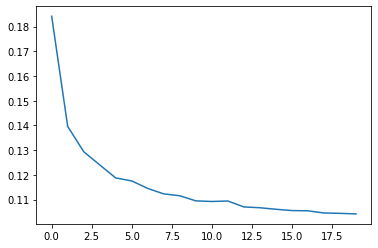

In [ ]:
plt.plot(history.history['loss'])

#### Take look at the final embeddings

In [ ]:
# Project data
z = encoder.predict(X)

Text(0.5, 1.0, 'UMAP embeddings')

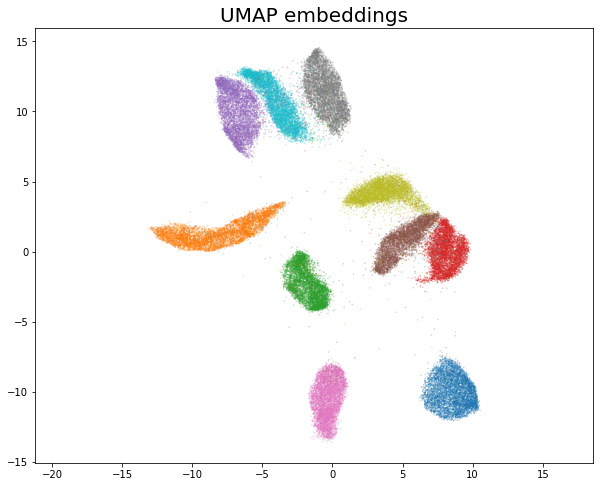

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=train_labels,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP embeddings", fontsize=20)